In [13]:
from Load_Data_for_Modelling import Get_data

data = Get_data(0,1800)
#df_Int, Interpoliertes_df = Interpolation(0,1800,1)

from Fensterung_Scaling_DeepLearning import Fensterung_Scale

# Falls Validations Daten benötigt werden
X_train_scaled, X_val_scaled, X_test_scaled, Y_train_scaled, Y_val_scaled, Y_test_scaled, Y_train, Y_val, Y_test, scalers_features, scaler_labels, Angepasste_Blechnummern_test = Fensterung_Scale(data, Validation_data=1, random=11, Train_Test_Split=2, window_size=10)
#X_train_scaled, X_val_scaled, X_test_scaled, Y_train_scaled, Y_val_scaled, Y_test_scaled, Y_train, Y_val, Y_test, scalers_features, scaler_labels, X_test_scaled_int, Y_test_interpolation, Blechnummern_Test_Int = Fensterung_Scale(df_Int, interpoliertesdf=Interpoliertes_df, Validation_data=1, random=8, Train_Test_Split=2, window_size=10, Interpolation=1)
# Falls keine Validationsdaten benötigt werden 
#X_train_scaled, X_test_scaled, Y_train_scaled, Y_test_scaled, Y_train, Y_test, scalers_features, scaler_labels = Fensterung_Scale(Validation_data=0, random=42)



Anzahl der Zeilen im finalen DataFrame: 255600
None
142
254180
142.0
Richtige Blechnummern umgerechnet der Validierungsdaten [143, 147, 169, 159, 62, 61, 160, 149, 164, 38, 142, 103, 50, 37]
Richtige Blechnummern umgerechnet der Testdaten [82, 130, 141, 114, 107, 19, 102, 64, 71, 109, 120, 104, 145, 34]
Blechnummern für Validierungsdaten, abgezählt vom Array nicht die Originaldaten [116, 120, 141, 131, 49, 48, 132, 122, 136, 25, 115, 78, 37, 24]
Blechnummern für Testdaten, abgezählt vom Array nicht die Originaldaten[69, 104, 114, 89, 82, 6, 77, 51, 58, 84, 95, 79, 118, 21]
25060
Shape nach dem Random Sampling des Arrays von X_val: (25060, 10, 11)
Shape nach dem Random Sampling des Arrays von X_train: (204060, 10, 11)
Shape nach dem Random Sampling des Arrays von Y_train: (204060, 1, 3)
(25060, 1, 3)
Shape für die Features der gesamten Trainingsdaten, also im Falle einer Interpolation mit allen Daten (204060, 10, 11)
Shape für die Features der gesamten Testdaten, also im Falle einer Int

In [19]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from keras import layers
from Load_Data_for_Modelling_Function import Data_for_Model
from Splitting_Scaling_Function import Split_Scaling
import matplotlib.pyplot as plt
import kerastuner as kt
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import shutil
import os
import json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import gc


tuner_directory = 'my_dir'
if os.path.exists(tuner_directory):
    shutil.rmtree(tuner_directory)
    
 # TensorFlow-Sitzung zurücksetzen
tf.keras.backend.clear_session()
gc.collect()
    
Y_train = np.squeeze(Y_train)
Y_test = np.squeeze(Y_test)
Y_val =np.squeeze(Y_val)
Y_train_scaled = np.squeeze(Y_train_scaled)
Y_val_scaled = np.squeeze(Y_val_scaled)

# CNN Modell definieren
input_layer = layers.Input(shape=(10,11))

#Hyperparametersuche 2 60 Trials
conv_1 = layers.Conv1D(filters=160, kernel_size=2, activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.01))(input_layer)
pool_1 = layers.MaxPooling1D(pool_size=2)(conv_1)
conv_2 = layers.Conv1D(filters=480, kernel_size=4, activation='relu', padding='same', strides=1, kernel_regularizer=keras.regularizers.l2(0.01))(pool_1)
pool_2 = layers.MaxPooling1D(pool_size=2)(conv_2)

flatten = layers.Flatten()(pool_2)

print(flatten)
print(type(flatten))
print(flatten.shape)

    
#Hyperparametersuche 3
dense_layer = layers.Dense(64, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.01))(flatten)

# Output Layers definieren
X_output = layers.Dense(1, activation='linear', name='Verstellweg_X')(dense_layer)
Y_output = layers.Dense(1, activation='linear', name='Verstellweg_Y')(dense_layer)
Phi_output = layers.Dense(1, activation='linear', name='Verstellweg_Phi')(dense_layer)

# Liste erstellen für alle Outputs
outputs = [X_output, Y_output, Phi_output]

# Modell definieren 
model = keras.Model(inputs=input_layer, outputs=outputs)

# Modell zusammenfassen
model.summary()

# Define early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


# Hyperparameter 3 60 Trials
model.compile(optimizer=keras.optimizers.Adam(0.0003255639325303961), 
            loss=['mean_absolute_error', 'mean_absolute_error', 'mean_absolute_error'], 
            metrics={'Verstellweg_X': 'mae', 'Verstellweg_Y': 'mae', 'Verstellweg_Phi': 'mae'})


CNN = model.fit(X_train_scaled, [Y_train[:,0], Y_train[:,1], Y_train[:,2]],
                            epochs=30,
                            validation_data=(X_val_scaled, [Y_val[:, 0], Y_val[:, 1], Y_val[:, 2]]),
                            callbacks=[early_stopping])

# Vorhersagen für den Testdatensatz erstellen
predictions1 = model.predict(X_test_scaled)
X_p, Y_p, Phi_p = predictions1

# predictions_int = model.predict(X_test_scaled_int)
# X_int, Y_int, Phi_int = predictions_int

 # MAE für den Testdatensatz berechnen
mae_X = mean_absolute_error(Y_test[:,0], X_p)
mae_Y = mean_absolute_error(Y_test[:,1], Y_p)
mae_Phi = mean_absolute_error(Y_test[:,2], Phi_p)

print(f"Mean Absolute Error for Verstellweg_X_ alleDaten: {mae_X}")
print(f"Mean Absolute Error for Verstellweg_Y_alleDaten: {mae_Y}")
print(f"Mean Absolute Error for Verstellweg_Phi_alleDaten: {mae_Phi}")

 # MAE für den Testdatensatz berechnen
# mae_X_int = mean_absolute_error(Y_test_interpolation[:,0], X_int)
# mae_Y_int = mean_absolute_error(Y_test_interpolation[:,1], Y_int)
# mae_Phi_int = mean_absolute_error(Y_test_interpolation[:,2], Phi_int)

# print(f"Mean Absolute Error for Verstellweg_X_ alleDaten: {mae_X_int}")
# print(f"Mean Absolute Error for Verstellweg_Y_alleDaten: {mae_Y_int}")
# print(f"Mean Absolute Error for Verstellweg_Phi_alleDaten: {mae_Phi_int}")

<KerasTensor shape=(None, 960), dtype=float32, sparse=False, name=keras_tensor_5>
<class 'keras.src.backend.common.keras_tensor.KerasTensor'>
(None, 960)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 10, 160)   │      3,680 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 5, 160)    │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 5, 480)    │    307,680 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 2, 480)    │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 960)       │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     61,504 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_X       │ (None, 1)         │         65 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Y       │ (None, 1)         │         65 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Verstellweg_Phi     │ (None, 1)         │         65 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 373,059 (1.42 MB)

 Trainable params: 373,059 (1.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
6377/6377 ━━━━━━━━━━━━━━━━━━━━ 80s 12ms/step - Verstellweg_Phi_mae: 0.5896 - Verstellweg_X_mae: 0.0390 - Verstellweg_Y_mae: 0.4689 - loss: 2.2999 - val_Verstellweg_Phi_mae: 0.8753 - val_Verstellweg_X_mae: 0.0135 - val_Verstellweg_Y_mae: 0.6012 - val_loss: 1.8070
Epoch 2/30
6377/6377 ━━━━━━━━━━━━━━━━━━━━ 76s 12ms/step - Verstellweg_Phi_mae: 0.2652 - Verstellweg_X_mae: 0.0126 - Verstellweg_Y_mae: 0.2009 - loss: 0.7761 - val_Verstellweg_Phi_mae: 1.0676 - val_Verstellweg_X_mae: 0.0111 - val_Verstellweg_Y_mae: 0.5681 - val_loss: 1.9158
Epoch 3/30
6377/6377 ━━━━━━━━━━━━━━━━━━━━ 76s 12ms/step - Verstellweg_Phi_mae: 0.2074 - Verstellweg_X_mae: 0.0078 - Verstellweg_Y_mae: 0.1691 - loss: 0.6481 - val_Verstellweg_Phi_mae: 1.0432 - val_Verstellweg_X_mae: 0.0039 - val_Verstellweg_Y_mae: 0.5545 - val_loss: 1.8490
Epoch 4/30
6377/6377 ━━━━━━━━━━━━━━━━━━━━ 77s 12ms/step - Verstellweg_Phi_mae: 0.1783 - Verstellweg_X_mae: 0.0051 - Verstellweg_Y_mae: 0.1503 - loss: 0.5755 - val_Verstellweg_Phi

In [39]:
# Analyse der Fehler des besten CNN in Form der Prädikationsfrequenz
import pandas as pd

Speichern=0
Ordner_window= r'C:\Users\corvi\OneDrive - stud.tu-darmstadt.de\Desktop\Masterthesis\13_ExcelvonDaten_Code\DeepLearning\CNN\Seed2\60Trials_Seed2_bestesModell\Blechsplit'

Fehler =pd.read_csv(f'{Ordner_window}\Fehler_CNN_Blechsplit_Randomseed2_Trial03_60Trials.csv', delimiter= ';')

columns = ['Label_X','Label_Y','Label_Phi','Fehler_X','Fehler_Y','Fehler_Phi']

for Column in columns:
         Fehler[Column] = Fehler[Column].astype(str).str.replace(',', '.')
         Fehler[Column] = Fehler[Column].astype(float)

Liste_Fehler =Fehler.drop(columns=['SplitMethode'])

# Sortieren nach Labels
Liste_Fehler_sortiert = Liste_Fehler.sort_values(by=['Label_X', 'Label_Y', 'Label_Phi'])  

if Speichern == 1:
       for Column in Liste_Fehler_sortiert.columns:
              Liste_Fehler_sortiert[Column] = Liste_Fehler_sortiert[Column].astype(str).str.replace('.', ',')

       Ordner = r'C:\Users\corvi\OneDrive - stud.tu-darmstadt.de\Desktop\Masterthesis\13_ExcelvonDaten_Code\DeepLearning\CNN\Test_Prädikationsfrequenz'

       Liste_Fehler_sortiert.to_csv(f'{Ordner}\Fehlerliste_RandomSeed2_nachLabel_sortiert.csv', index=True, sep=';')

print(Liste_Fehler.dtypes)
print(Liste_Fehler_sortiert)

Liste_Vorhersage = pd.DataFrame()
Liste_Vorhersage['X'] = Liste_Fehler_sortiert['Label_X'] - Liste_Fehler_sortiert['Fehler_X']
Liste_Vorhersage['Y'] = Liste_Fehler_sortiert['Label_Y'] - Liste_Fehler_sortiert['Fehler_Y']
Liste_Vorhersage['Phi'] = Liste_Fehler_sortiert['Label_Phi'] - Liste_Fehler_sortiert['Fehler_Phi']

X_p = Liste_Vorhersage['X']
Y_p = Liste_Vorhersage['Y']
Phi_p = Liste_Vorhersage['Phi']
Y_test = Liste_Fehler_sortiert.iloc[:,2:5]

print(X_p[::1])
print(Y_test.iloc[::1,0])

#print(Fehler)
Prädikationsfrequenz = (1,5,10,25,50,100)
liste_mae = []
# print(X_p)
# print(Fehler_X)
for i in Prädikationsfrequenz:
                
                # MAE für den Testdatensatz berechnen
        mae_X = mean_absolute_error(Y_test.iloc[::i,0], X_p[::i])
        mae_Y = mean_absolute_error(Y_test.iloc[::i,1], Y_p[::i])
        mae_Phi = mean_absolute_error(Y_test.iloc[::i,2], Phi_p[::i])
        
        print(f"Mean Absolute Error for Verstellweg_X: {mae_X}")
        print(f"Mean Absolute Error for Verstellweg_Y: {mae_Y}")
        print(f"Mean Absolute Error for Verstellweg_Phi: {mae_Phi}")
        
        MAEs = pd.DataFrame([{'Prädikationsfrequenz':i, 'Datentyp': 'Blechsplit', 'Error' : 'MAE', 'X': mae_X, 'Y': mae_Y, 'Phi': mae_Phi}])
        
        liste_mae.append(MAEs)
        
MAEs_ges = pd.concat(liste_mae,ignore_index=True)

Mean = MAEs_ges[['X','Y','Phi']].mean() 
Std = MAEs_ges[['X','Y','Phi']].std()

print(Mean)

MAEs_ges_Mean = pd.concat([MAEs_ges, pd.DataFrame([{'CV': 'Mittelwert', 'Datentyp': 'Blechsplit', 'Error' : 'MAE', 'X': Mean[0], 'Y': Mean[1], 'Phi': Mean[2]}])], ignore_index=True)
MAE_ges_all = pd.concat([MAEs_ges_Mean, pd.DataFrame([{'CV': 'Mittelwert', 'Datentyp': 'Blechsplit', 'Error' : 'MAE', 'X': Std[0], 'Y': Std[1], 'Phi': Std[2]}])], ignore_index=True)


for Column in MAE_ges_all.columns:
       MAE_ges_all[Column] = MAE_ges_all[Column].astype(str).str.replace('.', ',')

Ordner = r'C:\Users\corvi\OneDrive - stud.tu-darmstadt.de\Desktop\Masterthesis\13_ExcelvonDaten_Code\DeepLearning\CNN\Test_Prädikationsfrequenz'

MAE_ges_all.to_csv(f'{Ordner}\Prädikationsfrequenz_bestesCNN_MAEs_RandomAlle_sortiertnachLabels.csv', index=True, sep=';')


Unnamed: 0      int64
CV              int64
Label_X       float64
Label_Y       float64
Label_Phi     float64
Fehler_X      float64
Fehler_Y      float64
Fehler_Phi    float64
dtype: object
        Unnamed: 0  CV  Label_X  Label_Y  Label_Phi  Fehler_X  Fehler_Y  \
25062        25062  11     -6.0      0.0        0.0 -0.174433  0.362835   
25123        25123  11     -6.0      0.0        0.0 -0.160995  0.363765   
25136        25136  11     -6.0      0.0        0.0 -0.180141  0.362643   
25144        25144  11     -6.0      0.0        0.0 -0.246665  0.358937   
25157        25157  11     -6.0      0.0        0.0 -0.193095  0.361941   
...            ...  ..      ...      ...        ...       ...       ...   
225519      225519  32      4.0      4.0        0.0 -0.023316  3.877651   
225522      225522  32      4.0      4.0        0.0  0.063776  3.860234   
225525      225525  32      4.0      4.0        0.0  0.004342  3.910800   
225531      225531  32      4.0      4.0        0.0 -0.02063

C:\Users\corvi\AppData\Local\Temp\ipykernel_16868\1553876239.py:76: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  MAE_ges_all[Column] = MAE_ges_all[Column].astype(str).str.replace('.', ',')


1
      CV  Label  Label_X  Label_Y  Label_Phi  Fehler_X  Fehler_Y  Fehler_Phi
0     10      1      0.0      2.0        3.5  0.000679  0.465724    8.499403
1     10      1      0.0      2.0        3.5  0.001740  0.526690    8.978336
2     10      1      0.0      2.0        3.5  0.001301  0.194194    9.933014
3     10      1      0.0      2.0        3.5  0.001443  1.172130   11.139471
4     10      1      0.0      2.0        3.5  0.001228  0.130900    9.247184
...   ..    ...      ...      ...        ...       ...       ...         ...
1785  10      1      0.0      2.0        3.5  0.001542  0.316623    8.318836
1786  10      1      0.0      2.0        3.5  0.001202  0.359132   10.456544
1787  10      1      0.0      2.0        3.5  0.001593  0.953067   10.185748
1788  10      1      0.0      2.0        3.5  0.000634  1.813234    9.947912
1789  10      1      0.0      2.0        3.5  0.001593  0.094939    8.458070

[1790 rows x 8 columns]
2
      CV  Label  Label_X  Label_Y  Label_Phi  F

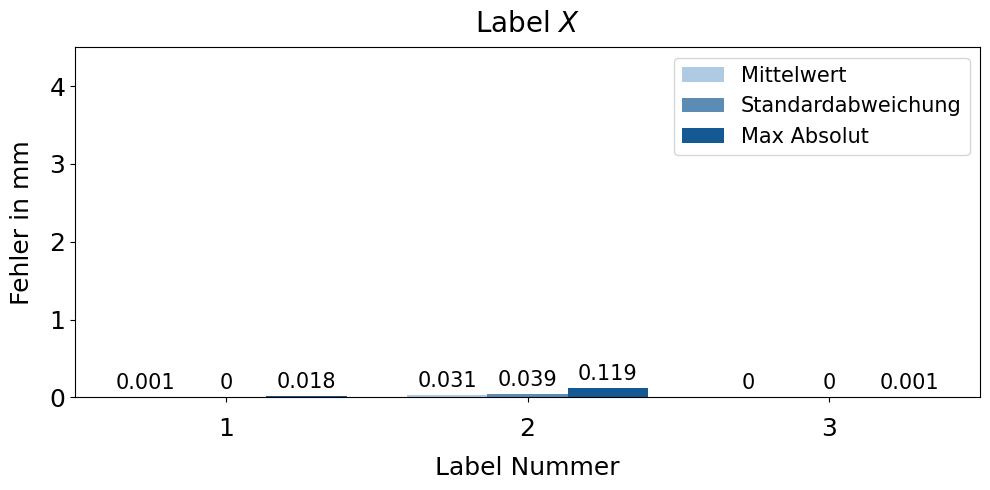

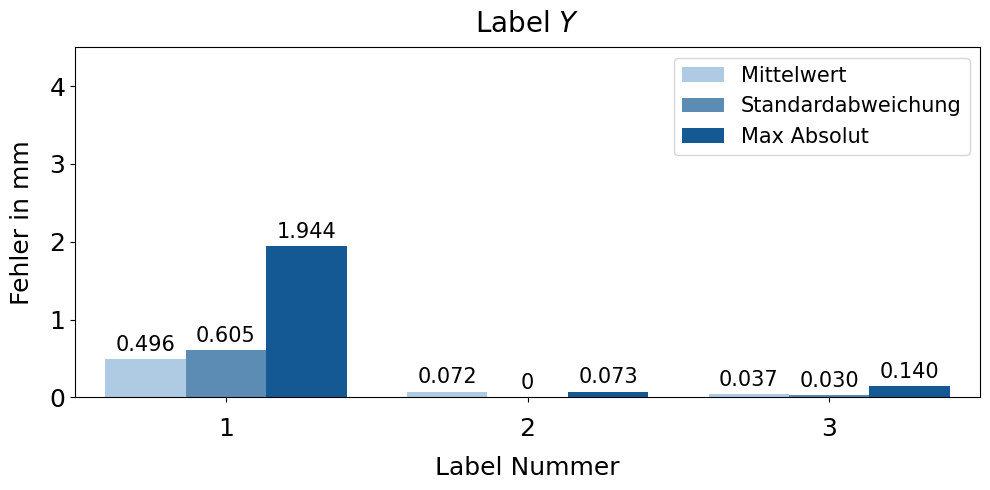

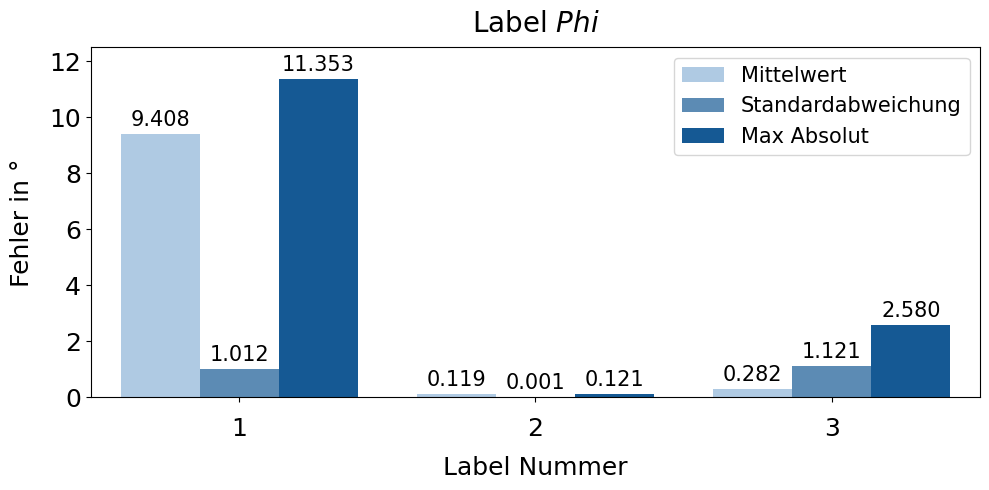

In [14]:
# Analyse der Fehler des besten CNN durch Analyse einzelner Labels und deren Ausreißer/Mittelwerte
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd
Speichern =0

Ordner_window= r'C:\Users\corvi\OneDrive - stud.tu-darmstadt.de\Desktop\Masterthesis\13_ExcelvonDaten_Code\DeepLearning\CNN\Seed2\60Trials_Seed2_bestesModell\Blechsplit'

Fehler =pd.read_csv(f'{Ordner_window}\Fehler_CNN_Blechsplit_Randomseed2_Trial03_60Trials.csv', delimiter= ';')

columns = ['Label_X','Label_Y','Label_Phi','Fehler_X','Fehler_Y','Fehler_Phi']

for Column in columns:
         Fehler[Column] = Fehler[Column].astype(str).str.replace(',', '.')
         Fehler[Column] = Fehler[Column].astype(float)

Liste_Fehler =Fehler.drop(columns=['SplitMethode','Unnamed: 0'])

# Sortieren nach Labels
Liste_Fehler_sortiert = Liste_Fehler.sort_values(by=['Label_X', 'Label_Y', 'Label_Phi'])  

# for Column in Liste_Fehler_sortiert.columns:
#        Liste_Fehler_sortiert[Column] = Liste_Fehler_sortiert[Column].astype(str).str.replace('.', ',')

# Ordner = r'C:\Users\corvi\OneDrive - stud.tu-darmstadt.de\Desktop\Masterthesis\13_ExcelvonDaten_Code\DeepLearning\CNN\Test_Prädikationsfrequenz'

# Liste_Fehler_sortiert.to_csv(f'{Ordner}\Fehlerliste_RandomSeed2_nachLabel_sortiert.csv', index=True, sep=';')

# Nach Labels von CV7 sortieren, um Ausreißer zu zeigen
Fehler_CV7 = Liste_Fehler_sortiert[Liste_Fehler_sortiert['CV']==7]
Fehler_CV10 = Liste_Fehler_sortiert[Liste_Fehler_sortiert['CV']==10]

# CV7 
# Label1 = Fehler_CV7.loc[(Fehler_CV7['Label_X'] == 0) & (Fehler_CV7['Label_Y'] == 0) & (Fehler_CV7['Label_Phi'] == -5.25)]
# Label2 = Fehler_CV7.loc[(Fehler_CV7['Label_X'] == 0) & (Fehler_CV7['Label_Y'] == -4) & (Fehler_CV7['Label_Phi'] == -3.5)]
# Label3 = Fehler_CV7.loc[(Fehler_CV7['Label_X'] == 0) & (Fehler_CV7['Label_Y'] == 6) & (Fehler_CV7['Label_Phi'] == 0)]

# CV10
Label1 = Fehler_CV10.loc[(Fehler_CV10['Label_X'] == 0) & (Fehler_CV10['Label_Y'] == 2) & (Fehler_CV10['Label_Phi'] == 3.5)]
Label2 = Fehler_CV10.loc[(Fehler_CV10['Label_X'] == -6) & (Fehler_CV10['Label_Y'] == 0) & (Fehler_CV10['Label_Phi'] == 0)]
Label3 = Fehler_CV10.loc[(Fehler_CV10['Label_X'] == 0) & (Fehler_CV10['Label_Y'] == 0) & (Fehler_CV10['Label_Phi'] == -7)]

Label1.insert(loc=1, column='Label', value=1)
Label2.insert(loc=1, column='Label', value=2)
Label3.insert(loc=1, column='Label', value=3)

liste_metrik = []
df_Labels = pd.concat([Label1,Label2,Label3], ignore_index=True)
#print(df_Labels)
# Schleife zur Berechnung der Statistiken
for label_value, Label_df in df_Labels.groupby('Label'):
    print(label_value)
    print(Label_df)    
    mean_values = Label_df[['Fehler_X', 'Fehler_Y', 'Fehler_Phi']].mean()
    std_values = Label_df[['Fehler_X', 'Fehler_Y', 'Fehler_Phi']].std()
    min_values = Label_df[['Fehler_X', 'Fehler_Y', 'Fehler_Phi']].min().abs()
    max_values = Label_df[['Fehler_X', 'Fehler_Y', 'Fehler_Phi']].max().abs()
    
    Mittelwert = pd.DataFrame([{'CV':10, 'Label': label_value, 'Metrik' : 'Mittelwert', 'Fehler_X': mean_values['Fehler_X'], 'Fehler_Y':mean_values['Fehler_Y'], 'Fehler_Phi':mean_values['Fehler_Phi']}])
    Std = pd.DataFrame([{'CV':10, 'Label': label_value, 'Metrik' : 'Standardabweichung', 'Fehler_X': std_values['Fehler_X'], 'Fehler_Y':std_values['Fehler_Y'], 'Fehler_Phi':std_values['Fehler_Phi']}])
      # Vergleiche und wähle den Maximalwert aus
    def choose_max_if_min_smaller(min_val, max_val):
        return max_val if min_val < max_val else min_val

    max_of_min_max_values = pd.DataFrame([{
        'CV': 10,
        'Label': label_value,
        'Metrik': 'Max Absolut',
        'Fehler_X': choose_max_if_min_smaller(min_values['Fehler_X'], max_values['Fehler_X']),
        'Fehler_Y': choose_max_if_min_smaller(min_values['Fehler_Y'], max_values['Fehler_Y']),
        'Fehler_Phi': choose_max_if_min_smaller(min_values['Fehler_Phi'], max_values['Fehler_Phi'])}])

    df_Metrik = pd.concat([Mittelwert,Std,max_of_min_max_values], ignore_index=True)

    liste_metrik.append(df_Metrik)
    
Ergebnisse = pd.concat(liste_metrik, ignore_index=True)

Y_test_CV7_Label2 = Label2['Label_Y']
Pred = Label2['Label_Y']-Label2['Fehler_Y']

Test_MAE_Label2_CV10 = mean_absolute_error(Y_test_CV7_Label2, Pred)
print(Test_MAE_Label2_CV10)

# Benenne die Spalten um
Ergebnisse_rename = Ergebnisse.rename(columns={
    'Fehler_X': 'Fehler X',
    'Fehler_Y': 'Fehler Y',
    'Fehler_Phi': 'Fehler Phi'})

# Berechnung der Absolutwerte für die Fehler-Spalten
Ergebnisse['Fehler_X'] = Ergebnisse['Fehler_X'].abs()
Ergebnisse['Fehler_Y'] = Ergebnisse['Fehler_Y'].abs()
Ergebnisse['Fehler_Phi'] = Ergebnisse['Fehler_Phi'].abs()

print(Ergebnisse)
# print(Liste_Fehler.dtypes)
# print(Liste_Fehler_sortiert)

# Benenne die Spalten um
Ergebnisse_rename = Ergebnisse.rename(columns={
    'Fehler_X': 'Fehler X',
    'Fehler_Y': 'Fehler Y',
    'Fehler_Phi': 'Fehler Phi'})

if Speichern ==1:

    for Column in Ergebnisse.columns:
          Ergebnisse[Column] = Ergebnisse[Column].astype(str).str.replace('.', ',')
        
    for Column in df_Labels.columns:
          df_Labels[Column] = df_Labels[Column].astype(str).str.replace('.', ',')

    Ordner = r'C:\Users\corvi\OneDrive - stud.tu-darmstadt.de\Desktop\Masterthesis\13_ExcelvonDaten_Code\DeepLearning\CNN\3Labels_Ausreißer_Mean_Std_Max_Min'

    Ergebnisse.to_csv(f'{Ordner}\Metriken_3Labels_Ausreißeranalyse_CV10.csv', index=True, sep=';')

    df_Labels.to_csv(f'{Ordner}\ListeFehler_fuer3Labels_Ausreißeranalyse_10.csv', index=True, sep=';')

# Beispielhafter Plot für MAE Testdaten
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Plot der MAE's aller konventionellen Methoden in Gegenüberstellung der unterschiedlichen Splits

Labels = ['Fehler X', 'Fehler Y', 'Fehler Phi']
Achse = ['X','Y','Phi']
Y_Achse = ['mm', 'mm', '°']

color_thesis1 =(0, 90/255, 169/255) # Dunkelblau aus Thesis
color_thesis2 =(166/255, 202/255, 236/255)  #Hellblau aus Abbildungen
color_thesis3 =(77/255, 140/255, 195/255) #mittleres Blau
#custom_palette = sns.color_palette(["#1f77b4", "#aec7e8", "#003f5c", "#7fbc41", "#2ca02c", "#98df8a"])
custom_palette = sns.color_palette([color_thesis2,color_thesis3,color_thesis1])


Sicherungsordner = f'C:\\Users\\corvi\\OneDrive - stud.tu-darmstadt.de\\Desktop\\Masterthesis\\15_Plots\\DeepLearning\\Ausreißer_CNN_fuer3Labels'     
# Sicherstellen, dass das Verzeichnis existiert
os.makedirs(Sicherungsordner, exist_ok=True)

# Schleife durch Metriken (X, y, phi)
for index, (Label, bezeichnung, Einheit) in enumerate(zip(Labels, Achse, Y_Achse)):
    plt.figure(figsize=(10,5))
    ax = sns.barplot(data=Ergebnisse_rename, x='Label', y=Label, hue='Metrik', palette=custom_palette, width=0.8)
    plt.title(f'Label $\\it{{{bezeichnung}}}$', fontsize=20, pad=11)
    ax.set_xlabel('Label Nummer', fontsize=18, labelpad=11)
    # Anpassen der Y-Achsen-Beschriftung mit kursivem 'mm' oder anderer Einheit
    ax.set_ylabel(f'Fehler in {Einheit}', fontsize=18, labelpad=11)  # MathText für Kursivschrift

    for p in ax.patches:
        height = p.get_height()
        display_value = 0 if height < 0.0009 else height
        ax.annotate(f'{display_value:.3f}' if display_value != 0 else '0',
                    xy=(p.get_x() + p.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=15)
        
        # Anpassen der Legende, um Titel dieser zu entfernen 
        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles[0:3], labels[0:3], title=None, loc='upper right', fontsize=15)
        #plt.legend(title='Metrik')

        # Problem mit Beschriftung der Balken (krzeut immer den Rand des Diagramms), deshalb wird hier der höchste Wert ermittelt und eine Obergrenze festgelegt
        max_value = Ergebnisse_rename[Label].max()  # Höchster Balkenwert
        # plt.ylim(0, max_value * 1.3)  
        plt.ylim(0,4.5)
        
        #Muss für CV 10 aktiviert werden
        if index ==2:
            plt.ylim(0,12.5)
        
        # X- und Y-Achsen Bereich, falls Schriftgröße angepasst werden muss
        ax.tick_params(axis='x', labelsize=18, pad=10.5)  
        ax.tick_params(axis='y', labelsize=18) 
        
        # y_ticks = np.arange(0, plt.ylim()[1] + 0.1, 0.5)  # Beispielhafte Intervalle
        # ax.set_yticks(y_ticks)
        
        plt.tight_layout()
        
        # Speicherung der Daten als png und svg
        plt.savefig(os.path.join(Sicherungsordner, f'{Label}_3Labels_Mittelwert_Std_max_CV10.svg'), format='svg')    
        plt.savefig(os.path.join(Sicherungsordner, f'{Label}_3Labels_Mittelwert_Std_max_CV10.png'), format='png')      

#plt.show()



In [34]:

# Aktuell bestes Modell aufbauen 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import kerastuner as kt
import shutil
import os
import json
import gc


def bestes_model(X_train_scaled, X_val_scaled, X_test_scaled, Y_train_scaled, Y_val_scaled, Y_test_scaled, Y_train, Y_val, Y_test, scalers_features, scaler_labels, windowsize):
      
    Y_train = np.squeeze(Y_train)
    Y_test = np.squeeze(Y_test)
    Y_val =np.squeeze(Y_val)
    Y_train_scaled = np.squeeze(Y_train_scaled)
    Y_val_scaled = np.squeeze(Y_val_scaled)
    
    # TensorFlow-Sitzung zurücksetzen
    tf.keras.backend.clear_session()
    gc.collect()

# CNN Modell definieren
    input_layer = layers.Input(shape=(windowsize,11))

    if windowsize <=1:
        #Hyperparametersuche 2 60 Trials
        conv_1 = layers.Conv1D(filters=160, kernel_size=2, activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.01))(input_layer)
        pool_1 = layers.MaxPooling1D(pool_size=1)(conv_1)
        conv_2 = layers.Conv1D(filters=480, kernel_size=4, activation='relu', padding='same', strides=1, kernel_regularizer=keras.regularizers.l2(0.01))(pool_1)
        pool_2 = layers.MaxPooling1D(pool_size=1)(conv_2)
        
    else:
              #Hyperparametersuche 2 60 Trials
        conv_1 = layers.Conv1D(filters=160, kernel_size=2, activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.01))(input_layer)
        pool_1 = layers.MaxPooling1D(pool_size=2)(conv_1)
        conv_2 = layers.Conv1D(filters=480, kernel_size=4, activation='relu', padding='same', strides=1, kernel_regularizer=keras.regularizers.l2(0.01))(pool_1)
        pool_2 = layers.MaxPooling1D(pool_size=2)(conv_2)
        
        
    flatten = layers.Flatten()(pool_2)
    
    #Hyperparametersuche 3
    dense_layer = layers.Dense(64, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.01))(flatten)

    # Output Layers definieren
    X_output = layers.Dense(1, activation='linear', name='Verstellweg_X')(dense_layer)
    Y_output = layers.Dense(1, activation='linear', name='Verstellweg_Y')(dense_layer)
    Phi_output = layers.Dense(1, activation='linear', name='Verstellweg_Phi')(dense_layer)

    # Liste erstellen für alle Outputs
    outputs = [X_output, Y_output, Phi_output]

    # Modell definieren 
    model = keras.Model(inputs=input_layer, outputs=outputs)
    
    # Hyperparameter 3 60 Trials
    model.compile(optimizer=keras.optimizers.Adam(0.0003255639325303961), 
                loss=['mean_absolute_error', 'mean_absolute_error', 'mean_absolute_error'], 
                metrics={'Verstellweg_X': 'mae', 'Verstellweg_Y': 'mae', 'Verstellweg_Phi': 'mae'})
    
    # Modell zusammenfassen
    #model.summary()

    # Define early stopping to prevent overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

    CNN = model.fit(X_train_scaled, [Y_train[:,0], Y_train[:,1], Y_train[:,2]],
                            epochs=20,
                            validation_data=(X_val_scaled, [Y_val[:, 0], Y_val[:, 1], Y_val[:, 2]]),
                            callbacks=[early_stopping])
    
    # Vorhersagen für den Testdatensatz erstellen
    predictions = model.predict(X_test_scaled)
    X_p, Y_p, Phi_p = predictions
    
    Fehler_X = Y_test[:,0]-X_p[:,0]
    Fehler_Y = Y_test[:,1]-Y_p[:,0]
    Fehler_Phi = Y_test[:,2]-Phi_p[:,0]
    
    # print(Fehler_X.shape)
    # print(Fehler_X)
    
    
    # Fehler in einen DataFrame konvertieren
    df_Fehler = pd.DataFrame({
        'Label_X': Y_test[:,0],
        'Label_Y': Y_test[:,1],
        'Label_Phi': Y_test[:,2],
        'Fehler_X': Fehler_X,
        'Fehler_Y': Fehler_Y,
        'Fehler_Phi': Fehler_Phi})
    

    #print(X_train_flat.shape)
    #print(X_val_flat.shape)
        #print(predictions)
    mae_X = mean_absolute_error(Y_test[:, 0], X_p)
    mae_Y = mean_absolute_error(Y_test[:, 1], Y_p)
    mae_Phi = mean_absolute_error(Y_test[:, 2], Phi_p)

    # X und Y kombinieren da diese zusammen sakliert werden
    # XY_p = np.column_stack((X_p, Y_p))

    # Rückskalierung der Vorhersagen
    # XY_pred = scaler_Y_mm.inverse_transform(XY_p)
    # X_pred, Y_pred = XY_pred[:, 0], XY_pred[:, 1]
    # Phi_pred = scaler_Y_phi.inverse_transform(Phi_p.reshape(-1, 1)).flatten()
    
    # MAE für den Testdatensatz berechnen
    # mae_X = mean_absolute_error(Y_test[:,0], X_p)
    # mae_Y = mean_absolute_error(Y_test[:,1], Y_p)
    # mae_Phi = mean_absolute_error(Y_test[:,2], Phi_p)

    print(f"Mean Absolute Error for Verstellweg_X: {mae_X}")
    print(f"Mean Absolute Error for Verstellweg_Y: {mae_Y}")
    print(f"Mean Absolute Error for Verstellweg_Phi: {mae_Phi}")
    
    return mae_X, mae_Y, mae_Phi, df_Fehler

In [35]:
# Variation Window Size Blechspit für alle 10 Random Durchläufe
import random 
from Load_Data_for_Modelling_Function import Data_for_Model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from Fensterung_Scaling_CNN_ValData_Interpolation_Test import Fensterung_Scale
from Load_Data_for_Modelling_Interpolation import Interpolation
from sklearn.metrics import mean_absolute_error
import pandas as pd


random.seed(2)
# Generieren einer Liste von 10 eindeutigen zufälligen Ganzzahlen zwischen 0 und 100
Random_numbers = random.sample(range(101), 10)
print(Random_numbers)

Window_size = (1,5,10,25,50,100)
Durchlauf = range(1,11,1)
windowsize =10
print(Durchlauf)
data = Data_for_Model(0,1800)


Liste_Fehler_Blechsplit = []
Liste_Fehler_Standardsplit= []

Liste_MAEs_Blechsplit =[]
Liste_MAEs_Standardsplit = []

MAE_StandardSplit_leer = pd.DataFrame(columns=['CV', 'Datentyp','Error', 'X', 'Y', 'Phi'])
MAE_BlechSplit_leer = pd.DataFrame(columns=['CV', 'Datentyp','Error', 'X', 'Y', 'Phi'])

# for n in Durchlauf:
    
#     X_train, X_val, X_test, Y_train_scaled, Y_val_scaled, Y_test_scaled, Y_train, Y_val, Y_test, scalers_features, scaler_labels, Angepasste_Blechnummern_test = Fensterung_Scale(data, Validation_data=1, random=11, Train_Test_Split =2, size=0.2)
#     mae_X, mae_Y, mae_phi, df_Fehler = bestes_model(X_train, X_val, X_test, Y_train_scaled, Y_val_scaled, Y_test_scaled, Y_train, Y_val, Y_test, scalers_features, scaler_labels, windowsize)
    
#     MAE_BlechSplit_df = pd.DataFrame([{'Durchlauf':n, 'Datentyp': 'Standardsplit', 'Error' : 'MAE', 'X': mae_X, 'Y': mae_Y, 'Phi': mae_phi}])
#     Liste_MAEs_Blechsplit.append(MAE_BlechSplit_df)
    
#     df_Fehler.insert(loc=0, column='SplitMethode', value='Standardsplit')
#     df_Fehler.insert(loc=1, column='CV', value=n)
#     Liste_Fehler_Blechsplit.append(df_Fehler)
    
# MAE_Blechsplit = pd.concat(Liste_MAEs_Blechsplit, ignore_index=True)
# Fehler_Blechsplit_df = pd.concat(Liste_Fehler_Blechsplit, ignore_index=True)

# Für Window Size EInfluss auf alle Random Splits
for n in Window_size:
    
    print(n)
    X_train, X_val, X_test, Y_train_scaled, Y_val_scaled, Y_test_scaled, Y_train, Y_val, Y_test, scalers_features, scaler_labels, Angepasste_Blechnummern_test   = Fensterung_Scale(data, Validation_data=1, random=10, Train_Test_Split =2, size=0.2, window_size=n)
    mae_X, mae_Y, mae_phi, df_Fehler = bestes_model(X_train, X_val, X_test, Y_train_scaled, Y_val_scaled, Y_test_scaled, Y_train, Y_val, Y_test, scalers_features, scaler_labels, n)
    
    MAE_BlechSplit_df = pd.DataFrame([{'Fenstergröße':n, 'Datentyp': 'Blechsplit', 'Error' : 'MAE', 'X': mae_X, 'Y': mae_Y, 'Phi': mae_phi}])
    Liste_MAEs_Blechsplit.append(MAE_BlechSplit_df)
    
    # df_Fehler.insert(loc=0, column='SplitMethode', value='Blechsplit')
    # df_Fehler.insert(loc=1, column='CV', value=n)
    # Liste_Fehler_Blechsplit.append(df_Fehler)
        
MAE_Blechsplit = pd.concat(Liste_MAEs_Blechsplit, ignore_index=True)
#Fehler_Blechsplit_df = pd.concat(Liste_Fehler_Blechsplit, ignore_index=True)
    
    
# Ausgabe der DataFrames
# print("MAE Standard Split:")
# print(MAE_StandardSplit_df)
# print("\nMAE Blech Split:")
# print(MAE_Standardsplit)

[7, 11, 10, 46, 21, 94, 85, 39, 32, 77]
range(1, 11)
Anzahl der Zeilen im finalen DataFrame: 255600
None
1
142
255458
142.0
Richtige Blechnummern umgerechnet der Validierungsdaten [22, 136, 151, 17, 66, 146, 153, 85, 55, 169, 163, 109, 33, 77]
Richtige Blechnummern umgerechnet der Testdaten [149, 154, 122, 60, 19, 67, 137, 31, 103, 59, 62, 159, 50, 132]
Blechnummern für Validierungsdaten, abgezählt vom Array nicht die Originaldaten [9, 110, 124, 4, 53, 119, 126, 72, 42, 141, 135, 84, 20, 64]
Blechnummern für Testdaten, abgezählt vom Array nicht die Originaldaten[122, 127, 96, 47, 6, 54, 111, 18, 78, 46, 49, 131, 37, 106]
25186
Shape nach dem Random Sampling des Arrays von X_val: (25186, 1, 11)
Shape nach dem Random Sampling des Arrays von X_train: (205086, 1, 11)
Shape nach dem Random Sampling des Arrays von Y_train: (205086, 1, 3)
(25186, 1, 3)
Shape für die Features der gesamten Trainingsdaten, also im Falle einer Interpolation mit allen Daten (205086, 1, 11)
Shape für die Features d

In [36]:
Ordner = r'C:\Users\corvi\OneDrive - stud.tu-darmstadt.de\Desktop\Masterthesis\13_ExcelvonDaten_Code\DeepLearning\CNN\Einfluss_WindowSize'

print(MAE_Blechsplit)
# print(Fehler_Blechsplit_df)
# print(MAE_Blechsplit)
Mean_Blech = MAE_Blechsplit[['X','Y','Phi']].mean() 
Std_Blech = MAE_Blechsplit[['X','Y','Phi']].std()

MAE_BlechSplit = pd.concat([MAE_Blechsplit, pd.DataFrame([{'Durchlauf': 'Mittelwert', 'Datentyp': 'Blechsplit', 'Error' : 'MAE', 'X': Mean_Blech[0], 'Y': Mean_Blech[1], 'Phi': Mean_Blech[2]}])], ignore_index=True)
MAE_BlechSplit_comp = pd.concat([MAE_BlechSplit, pd.DataFrame([{'Durchlauf': 'Standardabweichung', 'Datentyp': 'Blechsplit', 'Error' : 'MAE', 'X': Std_Blech[0], 'Y': Std_Blech[1], 'Phi': Std_Blech[2]}])], ignore_index=True)

# print(MAE_BlechSplit)
# print(MAE_StandardSplit)

for Column in MAE_BlechSplit_comp.columns:
        MAE_BlechSplit_comp[Column] = MAE_BlechSplit_comp[Column].astype(str).str.replace('.', ',')
        
# for Column in Fehler_Blechsplit_df:
#         Fehler_Blechsplit_df[Column] = Fehler_Blechsplit_df[Column].astype(str).str.replace('.', ',')

#Fehler_Blechsplit_df.to_csv(f'{Ordner}\Fehler_CNN_Blechsplit_Randomseed2_Modell3_Test_poolsize.csv', index=True, sep=';')

MAE_BlechSplit_comp.to_csv(f'{Ordner}\CNN_Blechsplit_Random10_EinflussWindowSize.csv', index=True, sep=';')

   Fenstergröße    Datentyp Error         X         Y       Phi
0             1  Blechsplit   MAE  0.044971  0.520352  1.377982
1             5  Blechsplit   MAE  0.024292  0.514936  1.323024
2            10  Blechsplit   MAE  0.015442  0.391860  1.315536
3            25  Blechsplit   MAE  0.005914  0.419908  1.219397
4            50  Blechsplit   MAE  0.020535  0.498717  1.401710
5           100  Blechsplit   MAE  0.014342  0.401483  1.316161


C:\Users\corvi\AppData\Local\Temp\ipykernel_16868\1211970913.py:16: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  MAE_BlechSplit_comp[Column] = MAE_BlechSplit_comp[Column].astype(str).str.replace('.', ',')
